<a href="https://colab.research.google.com/github/myeze/MachineLearningModels/blob/main/CNN_%2B_LSTM_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN-LSTM Model

**This notebook contains a model created by the AI Based Discovery and Innovation Finance Team**

---

**Myles's Additions:**

Added Hodges Tompkins, Rogers Satchell, and Yang-Zhang Estimation functions to calculate volatility and plots to show results

Added Documentation & Various Comments

---

This notebook contains code which aims to forcast future stock volatility (degree to which a stock's price changes over time) through the use of two separate approaches. One using historical stock data seen from various cap stocks as an input while another uses Garman-Klass Volatility.

Both approaches forcast by beginning with a Convolutional Neural Network (CNN) into a Long Short-Term Memory Network (LSTM).

This model's performance is then evaluated using Root Mean Squared Error (RMSE).

The notebook utilizes libraries such as pandas, yfinance, scikit-learn, and TensorFlow among others.

---
Historical Data Features:

* **ticker**
  * Unique identifier for the option contract
* **volume**
  * Number of option contracts traded within the specified window. (Higher volume can indicate increased market activity and a potentially higher volatility)
* **open**
  * Opening price of the option contract
* **close**
  * Closing price of the option contract
* **high**
  * Highest price of the option contract
* **low**
  * Lowest price of the option contract
* **window_start**
  * Starting timestamp of the window in which the data is agreed (Useful for understanding the time frame of the data and aligning it with other potential data sources)
* **transactions**
  *  Number of individual transactions in the specified window which occured for the option contract (higher transactions may indicate higher market activity)
* **underlying_ticker**
  * Ticker symbol of the underlying asset (stock) on which the option is based (Useful for linking the option data to the underlying asset's price data)
* **expiration_date**
  *  Date in which the option contract expires (Shorter times are generally more sensitive to changes in volatility and underlying asset price)
* **option_type**
  * Defines the specific right that the buyer is purchasing (Call or Put) (Both options behave differently in response to market movements meaning we can use this feature to segment the data or create interaction terms)
* **strike_price**
  * Price at which the underlying asset can be bought (for call option) or sold (for put option)
* **underlying_ticker_base**
  *  Represents the base currency or underlying asset of the option contract
---

Note from Topto:

1. Comment on overall:
- code is very linear and lacks modularity (especially before preprocessing part). So, redability and reusability is low, espeically for the complex data processing and model trainig steps.
- code should be documented

---

Sources:

https://www.pyquantnews.com/the-pyquant-newsletter/how-to-compute-volatility-6-ways

In [2]:
# Prepare to download historical data from Google Drive
!pip install gdown

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import mean_squared_error

In [4]:
# Begin by downloading the historical option data
# If the zip is already downloaded, it can be extracted to the same directory
# "/content/Data" on Google Colab
file_url = 'https://drive.google.com/uc?id=1kvRqUf5OU7QMl9XaacxNFAqAndA6JgX3'

!gdown {file_url} --output "Historical_Option_Data.zip"

import zipfile
with zipfile.ZipFile("Historical_Option_Data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/Data")

Downloading...
From (original): https://drive.google.com/uc?id=1kvRqUf5OU7QMl9XaacxNFAqAndA6JgX3
From (redirected): https://drive.google.com/uc?id=1kvRqUf5OU7QMl9XaacxNFAqAndA6JgX3&confirm=t&uuid=d0f3fec8-4cb9-4188-bfc7-4c5b7c9005ac
To: /content/Historical_Option_Data.zip
100% 1.49G/1.49G [00:16<00:00, 89.3MB/s]


In [5]:
# Specify the stock we want to analyze
ticker = input("Ticker:")

Ticker:SPY


In [6]:
# Create the file path and read the data from it
file_path = f"/content/Data/Historical Option Data/{ticker}_options_data.csv"
optionsdf = pd.read_csv(file_path)
optionsdf

,ticker,volume,open,close,high,low,window_start,transactions,underlying_ticker,expiration_date,option_type,strike_price,underlying_ticker_base
0,O:SPY221115C00350000,7,51.60,48.37,51.60,48.37,2022-11-15 05:00:00,3,SPYC,2022-11-15,Put,350.0,SPY
1,O:SPY221115C00360000,40,41.29,37.85,41.29,37.85,2022-11-15 05:00:00,5,SPYC,2022-11-15,Put,360.0,SPY
2,O:SPY221115C00370000,51,31.82,28.85,31.82,27.92,2022-11-15 05:00:00,5,SPYC,2022-11-15,Put,370.0,SPY
3,O:SPY221115C00376000,77,24.67,22.52,24.67,20.84,2022-11-15 05:00:00,8,SPYC,2022-11-15,Put,376.0,SPY
4,O:SPY221115C00378000,235,24.14,20.61,24.14,17.78,2022-11-15 05:00:00,9,SPYC,2022-11-15,Put,378.0,SPY
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028433,O:SPY270115P00610000,2,58.74,58.25,58.74,58.25,2024-10-09 04:00:00,2,SPY,2027-01-15,Put,610.0,SPY
2028434,O:SPY270115P00630000,8,68.30,67.43,68.30,67.43,2024-10-09 04:00:00,4,SPY,2027-01-15,Put,630.0,SPY
2028435,O:SPY270115P00635000,2,72.56,72.24,72.56,72.24,2024-10-09 04:00:00,2,SPY,2027-01-15,Put,635.0,SPY
2028436,O:SPY270115P00660000,1,88.00,88.00,88.00,88.00,2024-10-09 04:00:00,1,SPY,2027-01-15,Put,660.0,SPY


In [11]:
# Download the stock data from October 10th, 2022 to Octover 10th 2024 for the specified ticker
startDate = datetime.datetime(2022, 10,10)
endDate = datetime.datetime(2024, 10, 10)
stockdf = yf.download(ticker, startDate, endDate)
stockdf

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,
2022-10-10 00:00:00+00:00,349.711334,360.019989,364.209991,357.670013,363.959991,76042800
2022-10-11 00:00:00+00:00,347.496613,357.739990,363.029999,355.709991,358.239990,92482800
2022-10-12 00:00:00+00:00,346.350403,356.559998,359.820007,356.299988,358.170013,76991800
2022-10-13 00:00:00+00:00,355.490936,365.970001,367.510010,348.109985,349.209991,147254500
2022-10-14 00:00:00+00:00,347.389771,357.630005,370.260010,356.959991,368.549988,123737000
...,...,...,...,...,...,...
2024-10-03 00:00:00+00:00,567.820007,567.820007,569.799988,565.489990,567.359985,40846500
2024-10-04 00:00:00+00:00,572.979980,572.979980,573.359985,568.099976,572.349976,42939100


In [12]:
# Calculate the "unbias" factor
def calcUnbiasFactor(data_df):

  no_of_rows = data_df.shape

  no_of_rows = no_of_rows[0]

  # Unbias factor (Explain why specific formula was used)
  unbias_factor = ((1)-(1/(4*no_of_rows)))

  return unbias_factor

In [15]:
# Calculate the Parkinson Volatility Estimator for a given price dataset
def parkinson(price_data, window=30, trading_periods=252, clean=True):

    # Calculate the Unbias Factor
    unbias_factor = calcUnbiasFactor(price_data)

    # Calculate the PVE
    rs = (1.0 / (4.0 * math.log(2.0))) * ((price_data['High'] / price_data['Low']).apply(np.log))**2.0

    # Helper function to calculate volatility using training periods
    def f(v):
        return (trading_periods * v.mean())**0.5

    # Calculate the volatility over time
    result = rs.rolling( window=window, center=False).apply(func=f)

    # Apply the unbias factor to the volatility estimate
    result *= unbias_factor

    # Remove rows with missing values
    if clean:
        return result.dropna()
    else:
        return result

Ticker,SPY
Date,
2022-11-18 00:00:00+00:00,0.213631
2022-11-21 00:00:00+00:00,0.211752
2022-11-22 00:00:00+00:00,0.209873
2022-11-23 00:00:00+00:00,0.209763
2022-11-25 00:00:00+00:00,0.187441
...,...
2024-10-03 00:00:00+00:00,0.113947
2024-10-04 00:00:00+00:00,0.112205
2024-10-07 00:00:00+00:00,0.111941


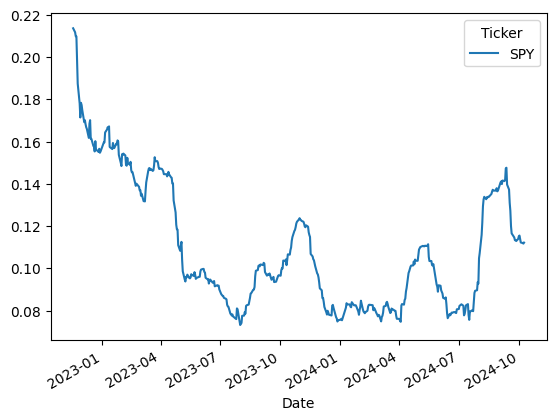

In [16]:
# Find the PVE for our given stocks
volatility = parkinson(stockdf)
volatility.plot()
volatility

In [17]:
# Calculate the Garman Klass Volatility Estimator for a given price dataset
def garman_klass(price_data, window=30, trading_periods=252, clean=True):

    # Calculate the Unbias Factor
    unbias_factor = calcUnbiasFactor(price_data)

    # Calculate the logarithmic returns of high/low and close/open prices
    log_hl = (price_data['High'] / price_data['Low']).apply(np.log)
    log_co = (price_data['Close'] / price_data['Open']).apply(np.log)

    # Calculate the variance of the volatility
    rs = 0.5 * log_hl**2 - (2*math.log(2)-1) * log_co**2

    # Helper function to calculate volatility using training periods
    def f(v):
        return (trading_periods * v.mean())**0.5

    # Calculate the volatility over time
    result = rs.rolling(window=window, center=False).apply(func=f)

    # Remove rows with missing values
    if clean:
        return result.dropna()*unbias_factor
    else:
        return result*unbias_factor


In [18]:
""" Is there any particular reason as to why we need to run this again? """
startDate = datetime.datetime(2022, 10,10)
endDate = datetime.datetime(2024, 10, 10)
stockdf = yf.download(ticker, startDate, endDate)
stockdf

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,
2022-10-10 00:00:00+00:00,349.711334,360.019989,364.209991,357.670013,363.959991,76042800
2022-10-11 00:00:00+00:00,347.496613,357.739990,363.029999,355.709991,358.239990,92482800
2022-10-12 00:00:00+00:00,346.350403,356.559998,359.820007,356.299988,358.170013,76991800
2022-10-13 00:00:00+00:00,355.490936,365.970001,367.510010,348.109985,349.209991,147254500
2022-10-14 00:00:00+00:00,347.389771,357.630005,370.260010,356.959991,368.549988,123737000
...,...,...,...,...,...,...
2024-10-03 00:00:00+00:00,567.820007,567.820007,569.799988,565.489990,567.359985,40846500
2024-10-04 00:00:00+00:00,572.979980,572.979980,573.359985,568.099976,572.349976,42939100


Ticker,SPY
Date,
2022-11-18 00:00:00+00:00,0.204460
2022-11-21 00:00:00+00:00,0.202682
2022-11-22 00:00:00+00:00,0.199422
2022-11-23 00:00:00+00:00,0.199010
2022-11-25 00:00:00+00:00,0.185559
...,...
2024-10-03 00:00:00+00:00,0.119404
2024-10-04 00:00:00+00:00,0.118843
2024-10-07 00:00:00+00:00,0.118274


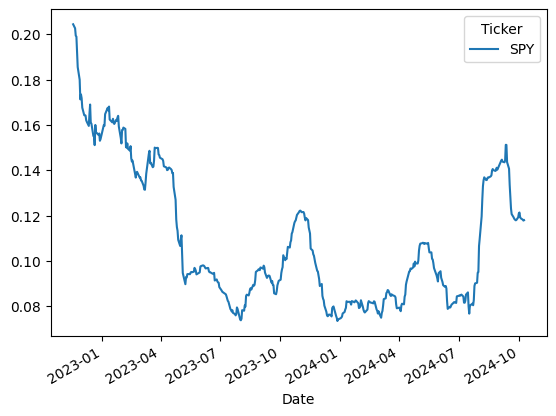

In [19]:
# Find the PVE for our given stocks
volatility = garman_klass(stockdf)
volatility.plot()
volatility

In [23]:
def close_to_close(price_data, window=30, trading_periods=252, clean=True):

    # Calculate the Unbias Factor
    unbias_factor = calcUnbiasFactor(price_data)

    log_return = (price_data['Close'] / price_data['Close'].shift(1)).apply(np.log)

    result = log_return.rolling(window=window, center=False).std() * math.sqrt(trading_periods)

    if clean:
        return result.dropna()*unbias_factor
    else:
        return result*unbias_factor

Ticker,SPY
Date,
2022-11-21 00:00:00+00:00,0.268111
2022-11-22 00:00:00+00:00,0.268189
2022-11-23 00:00:00+00:00,0.267449
2022-11-25 00:00:00+00:00,0.259381
2022-11-28 00:00:00+00:00,0.253999
...,...
2024-10-03 00:00:00+00:00,0.126151
2024-10-04 00:00:00+00:00,0.126007
2024-10-07 00:00:00+00:00,0.125896


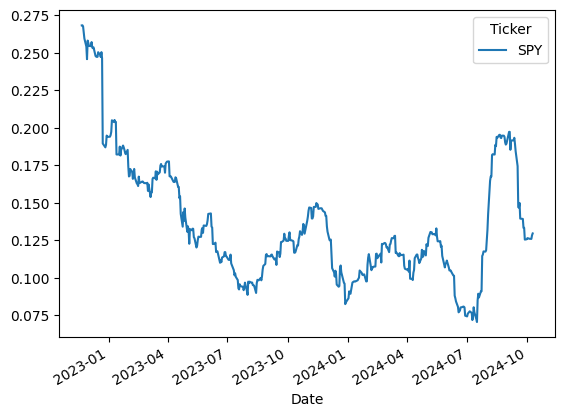

In [24]:
close_to_close_volatility = close_to_close(stockdf)
close_to_close_volatility.plot()
close_to_close_volatility

In [25]:
# Calculate the Hodges Tompkins Volatility Estimator for a given price dataset
def hodges_tompkins(price_data, window=30, trading_periods=252, clean=True):

    # Calculate the Unbias Factor
    unbias_factor = calcUnbiasFactor(price_data)

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    vol = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    h = window
    n = (log_return.count() - h) + 1

    adj_factor = 1.0 / (1.0 - (h / n) + ((h ** 2 - 1) / (3 * n ** 2)))

    result = vol * adj_factor

    # Remove rows with missing values
    if clean:
        return result.dropna()*unbias_factor
    else:
        return result*unbias_factor

Ticker,SPY
Date,
2022-11-21 00:00:00+00:00,0.285859
2022-11-22 00:00:00+00:00,0.285942
2022-11-23 00:00:00+00:00,0.285152
2022-11-25 00:00:00+00:00,0.276551
2022-11-28 00:00:00+00:00,0.270813
...,...
2024-10-03 00:00:00+00:00,0.134502
2024-10-04 00:00:00+00:00,0.134348
2024-10-07 00:00:00+00:00,0.134230


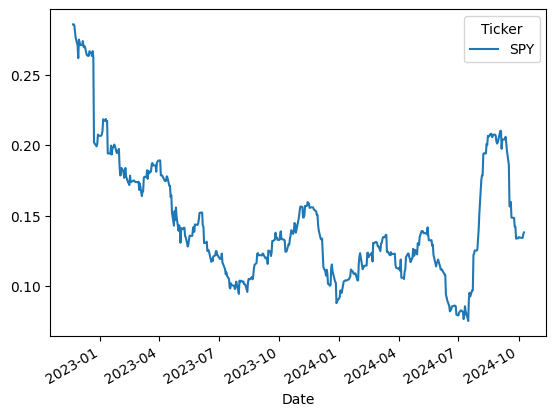

In [26]:
volatility = hodges_tompkins(stockdf)
volatility.plot()
volatility

In [27]:
# Calculate the Rogers Satchell Volatility Estimator for a given price dataset
def rogers_satchell(price_data, window=30, trading_periods=252, clean=True):

    # Calculate the Unbias Factor
    unbias_factor = calcUnbiasFactor(price_data)

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    # Remove rows with missing values
    if clean:
        return result.dropna()*unbias_factor
    else:
        return result*unbias_factor

""" Is there any particular reason as to why we need to run this again? """
startDate = datetime.datetime(2022, 10,10)
endDate = datetime.datetime(2024, 10, 10)
stockdf = yf.download(ticker, startDate, endDate)
stockdf

Ticker,SPY
Date,
2022-11-18 00:00:00+00:00,0.202402
2022-11-21 00:00:00+00:00,0.200566
2022-11-22 00:00:00+00:00,0.196616
2022-11-23 00:00:00+00:00,0.195968
2022-11-25 00:00:00+00:00,0.187945
...,...
2024-10-03 00:00:00+00:00,0.124660
2024-10-04 00:00:00+00:00,0.125363
2024-10-07 00:00:00+00:00,0.124686


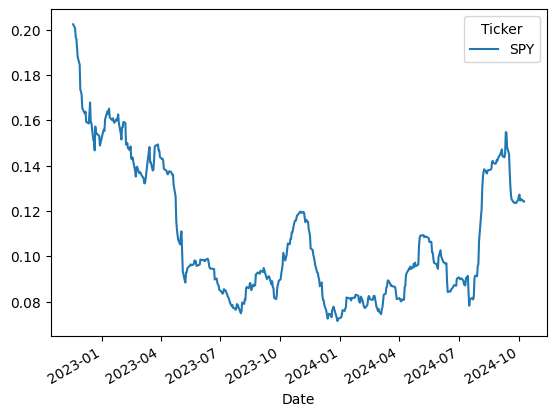

In [28]:
volatility = rogers_satchell(stockdf)
volatility.plot()
volatility

In [31]:
# Calculate the Yang-Zhang Volatility Estimator for a given price dataset
def yang_zhang(price_data, window=30, trading_periods=252, clean=True):

    # Calculate the Unbias Factor
    unbias_factor = calcUnbiasFactor(price_data)

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    log_oc = (price_data["Open"] / price_data["Close"].shift(1)).apply(np.log)
    log_oc_sq = log_oc ** 2

    log_cc = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)
    log_cc_sq = log_cc ** 2

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    close_vol = log_cc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    open_vol = log_oc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    window_rs = rs.rolling(window=window, center=False).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1.34 + (window + 1) / (window - 1))
    result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(
        np.sqrt
    ) * math.sqrt(trading_periods)

    # Remove rows with missing values
    if clean:
        return result.dropna()*unbias_factor
    else:
        return result*unbias_factor

Ticker,SPY
Date,
2022-11-21 00:00:00+00:00,0.282397
2022-11-22 00:00:00+00:00,0.280252
2022-11-23 00:00:00+00:00,0.279900
2022-11-25 00:00:00+00:00,0.266512
2022-11-28 00:00:00+00:00,0.264073
...,...
2024-10-03 00:00:00+00:00,0.146629
2024-10-04 00:00:00+00:00,0.148744
2024-10-07 00:00:00+00:00,0.147336


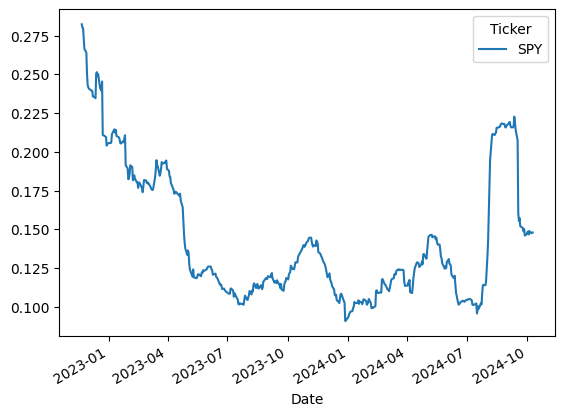

In [32]:
volatility = yang_zhang(stockdf)
volatility.plot()
volatility

Below is the the use of the CNN LSTM architecture in the attempt to forecast realized volatility.

Preprocessing the dataframe

In [ ]:
data = stockdf
data

Price,Adj Close,Close,High,Low,Open,Volume,Return,Volatility,Future_Volatility
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA,,,
Date,,,,,,,,,


In [ ]:
data.columns

MultiIndex([('Adj Close', 'TSLA'),
            (    'Close', 'TSLA'),
            (     'High', 'TSLA'),
            (      'Low', 'TSLA'),
            (     'Open', 'TSLA'),
            (   'Volume', 'TSLA')],
           names=['Price', 'Ticker'])

In [ ]:
# Calculate daily returns
data['Return'] = data['Adj Close'].pct_change()

# Display the first few rows with returns
print(data[['Adj Close', 'Return']].head())

Empty DataFrame
Columns: [(Adj Close, TSLA), (Return, )]
Index: []


In [ ]:
data

Price,Adj Close,Close,High,Low,Open,Volume,Return
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA,
Date,,,,,,,
2022-10-10 00:00:00+00:00,222.960007,222.960007,226.990005,218.360001,223.929993,67925000,NaN
2022-10-11 00:00:00+00:00,216.500000,216.500000,225.750000,215.000000,220.949997,77013200,-0.028974
2022-10-12 00:00:00+00:00,217.240005,217.240005,219.300003,211.509995,215.330002,66860700,0.003418
2022-10-13 00:00:00+00:00,221.720001,221.720001,222.990005,206.220001,208.300003,91483000,0.020622
2022-10-14 00:00:00+00:00,204.990005,204.990005,226.259995,204.160004,224.009995,94124500,-0.075456
...,...,...,...,...,...,...,...
2024-10-03 00:00:00+00:00,240.660004,240.660004,249.789993,237.809998,244.479996,80729200,-0.033572
2024-10-04 00:00:00+00:00,250.080002,250.080002,250.960007,244.580002,246.690002,86573200,0.039142


Price                     Volatility Future_Volatility
Ticker                                                
Date                                                  
2024-08-14 00:00:00+00:00   0.535170          0.394120
2024-08-15 00:00:00+00:00   0.534215          0.390063
2024-08-16 00:00:00+00:00   0.533275          0.389058
2024-08-19 00:00:00+00:00   0.525343          0.400984
2024-08-20 00:00:00+00:00   0.522362          0.402221
2024-08-21 00:00:00+00:00   0.519580          0.410202
2024-08-22 00:00:00+00:00   0.488426          0.404657
2024-08-23 00:00:00+00:00   0.473621          0.404520
2024-08-26 00:00:00+00:00   0.465397          0.402565
2024-08-27 00:00:00+00:00   0.460204          0.400143


In [ ]:
# Calculate rolling volatility (standard deviation of returns over a 10-day window)

data['Volatility'] = data['Return'].rolling(window=10).std()

# Shift volatility to get future volatility
data['Future_Volatility'] = data['Volatility'].shift(-1)

# Drop rows with NaN values
data.dropna(inplace=True)

# Display the last few rows
print(data[['Volatility', 'Future_Volatility']].tail(10))

Price                     Volatility Future_Volatility
Ticker                                                
Date                                                  
2024-09-24 00:00:00+00:00   0.031463          0.029610
2024-09-25 00:00:00+00:00   0.029610          0.028899
2024-09-26 00:00:00+00:00   0.028899          0.026074
2024-09-27 00:00:00+00:00   0.026074          0.025962
2024-09-30 00:00:00+00:00   0.025962          0.026697
2024-10-01 00:00:00+00:00   0.026697          0.029201
2024-10-02 00:00:00+00:00   0.029201          0.044541
2024-10-03 00:00:00+00:00   0.044541          0.043104
2024-10-04 00:00:00+00:00   0.043104          0.051976
2024-10-07 00:00:00+00:00   0.051976          0.053128


In [ ]:
# Features: Return and Volatility
features = data[['Return', 'Volatility']].values

# Target: Future Volatility
target = data['Future_Volatility'].values
# USES -> from sklearn.preprocessing import MinMaxScaler

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale features and target
scaled_features = scaler_X.fit_transform(features)
scaled_target = scaler_y.fit_transform(target.reshape(-1, 1))

In [ ]:
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Create sequences
time_steps = 10
X, y = create_sequences(scaled_features, scaled_target, time_steps)

# Display the shape of the data
print(f"Feature shape: {X.shape}, Target shape: {y.shape}")

Feature shape: (482, 10, 2), Target shape: (482, 1)


In [ ]:
# USES -> from tensorflow.keras.models import Sequential
# USES -> from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

# Define the model
model = Sequential()
# Convolutional layer
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X.shape[1], X.shape[2])))
# Max pooling layer
model.add(MaxPooling1D(pool_size=2))
# LSTM layer
model.add(LSTM(50))
# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Display the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 9, 64)               │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          23,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,371 (91.29 KB)

 Trainable params: 23,371 (91.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
# Predict on test data
y_pred = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [ ]:
# Inverse transform to get actual volatility values
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

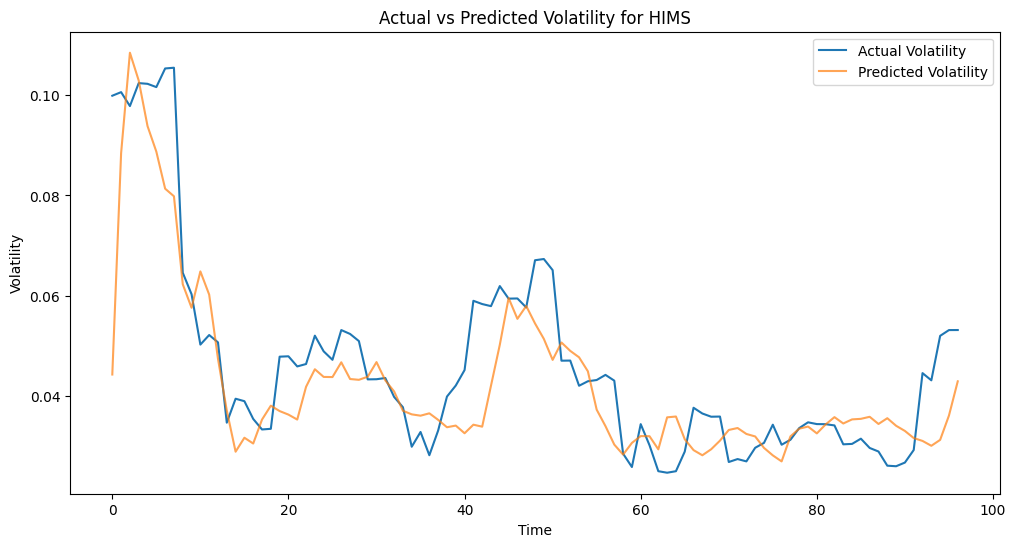

In [ ]:
# Plot the actual and predicted volatility
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Volatility')
plt.plot(y_pred_inv, label='Predicted Volatility', alpha=0.7)
plt.title(f'Actual vs Predicted Volatility for {ticker.upper()}')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [ ]:
# USES from sklearn.metrics import mean_squared_error

# Calculate MSE
rmse = mean_squared_error(y_test_inv, y_pred_inv, squared = False)
print(f"Root Mean Squared Error for {ticker.upper()}: {mse:.6f}")

Mean Squared Error for HIMS: 0.010786


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
startDate = datetime.datetime(2022, 10,10)
endDate = datetime.datetime(2024, 10, 10)
data = yf.download(ticker, startDate, endDate)
data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2022-10-10 00:00:00+00:00,222.960007,222.960007,226.990005,218.360001,223.929993,67925000
2022-10-11 00:00:00+00:00,216.500000,216.500000,225.750000,215.000000,220.949997,77013200
2022-10-12 00:00:00+00:00,217.240005,217.240005,219.300003,211.509995,215.330002,66860700
2022-10-13 00:00:00+00:00,221.720001,221.720001,222.990005,206.220001,208.300003,91483000
2022-10-14 00:00:00+00:00,204.990005,204.990005,226.259995,204.160004,224.009995,94124500
...,...,...,...,...,...,...
2024-10-03 00:00:00+00:00,240.660004,240.660004,249.789993,237.809998,244.479996,80729200
2024-10-04 00:00:00+00:00,250.080002,250.080002,250.960007,244.580002,246.690002,86573200


In [ ]:
# Add Garman-Klass Volatility to the DataFrame
data['Volatility'] = garman_klass(data)

# Calculate Future Volatility: Volatility over the next 30 days
data['Future_Volatility'] = data['Volatility'].shift(-30)

# Drop rows with NaN values resulting from the shift
data.dropna(inplace=True)

print(data[['Volatility', 'Future_Volatility']].tail(10))

Price                     Volatility Future_Volatility
Ticker                                                
Date                                                  
2024-08-14 00:00:00+00:00   0.535170          0.394120
2024-08-15 00:00:00+00:00   0.534215          0.390063
2024-08-16 00:00:00+00:00   0.533275          0.389058
2024-08-19 00:00:00+00:00   0.525343          0.400984
2024-08-20 00:00:00+00:00   0.522362          0.402221
2024-08-21 00:00:00+00:00   0.519580          0.410202
2024-08-22 00:00:00+00:00   0.488426          0.404657
2024-08-23 00:00:00+00:00   0.473621          0.404520
2024-08-26 00:00:00+00:00   0.465397          0.402565
2024-08-27 00:00:00+00:00   0.460204          0.400143


In [ ]:
# this is the garman klass use for the CNN
from sklearn.preprocessing import MinMaxScaler

# Prepare the data
volatility_values = data['Volatility'].values.reshape(-1, 1)
future_volatility_values = data['Future_Volatility'].values.reshape(-1, 1)

# If scaling is desired
scaler = MinMaxScaler()
volatility_values = scaler.fit_transform(volatility_values)

# Future volatility values
future_volatility_values = data['Future_Volatility'].values
future_volatility_values = future_volatility_values.reshape(-1, 1)
future_volatility_values = scaler.transform(future_volatility_values)

In [ ]:
# Create sequences
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - 2 * time_steps + 1):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[(i + time_steps):(i + 2 * time_steps)])
    return np.array(Xs), np.array(ys)

time_steps = 30
X, y = create_sequences(volatility_values, future_volatility_values, time_steps)

# Reshape X to have the third dimension
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape((y.shape[0], y.shape[1], 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, LSTM, TimeDistributed, Dense

# Define the model
model = Sequential()
model.add(Input(shape=(time_steps, 1)))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(1)))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.0363 - val_loss: 0.0620
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0223 - val_loss: 0.0664
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0162 - val_loss: 0.0464
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0175 - val_loss: 0.0546
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0153 - val_loss: 0.0437
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0160 - val_loss: 0.0566
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0148 - val_loss: 0.0467
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0159 - val_loss: 0.0554
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0167 - val_loss: 0.0495
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0149 - val_loss: 0.0513
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0150 - val_loss: 0.0534
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


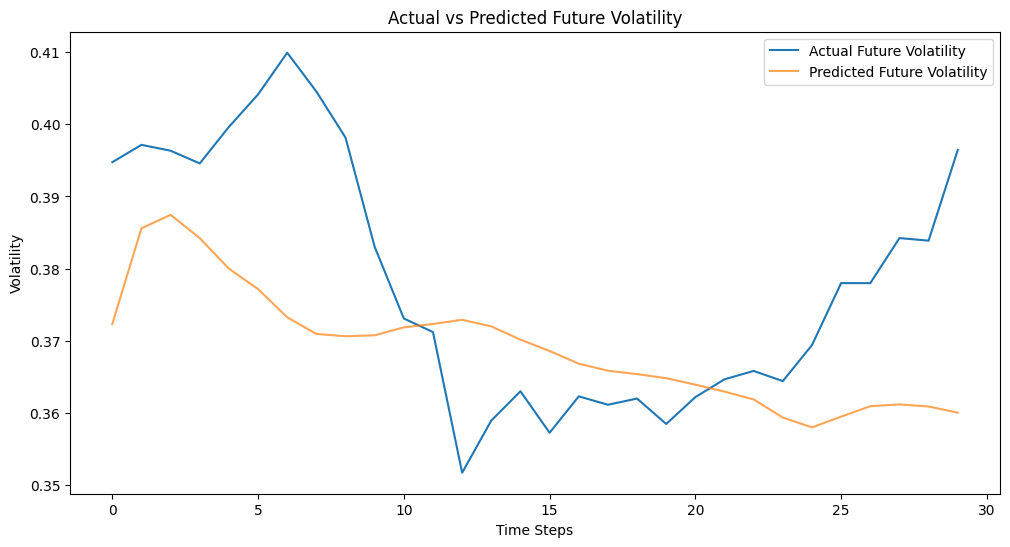

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform if scaling was applied
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

# Plotting the results for the first sample in the test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[0], label='Actual Future Volatility')
plt.plot(y_pred_inv[0], label='Predicted Future Volatility', alpha=0.7)
plt.title('Actual vs Predicted Future Volatility')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Reshape the arrays to 2D by removing the last dimension
y_test_flat = y_test_inv.reshape(y_test_inv.shape[0], y_test_inv.shape[1])
y_pred_flat = y_pred_inv.reshape(y_pred_inv.shape[0], y_pred_inv.shape[1])

# Flatten the arrays to 1D
y_test_flat = y_test_flat.flatten()
y_pred_flat = y_pred_flat.flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))

print(f"RMSE: {rmse:.4f}")

RMSE: 0.0875


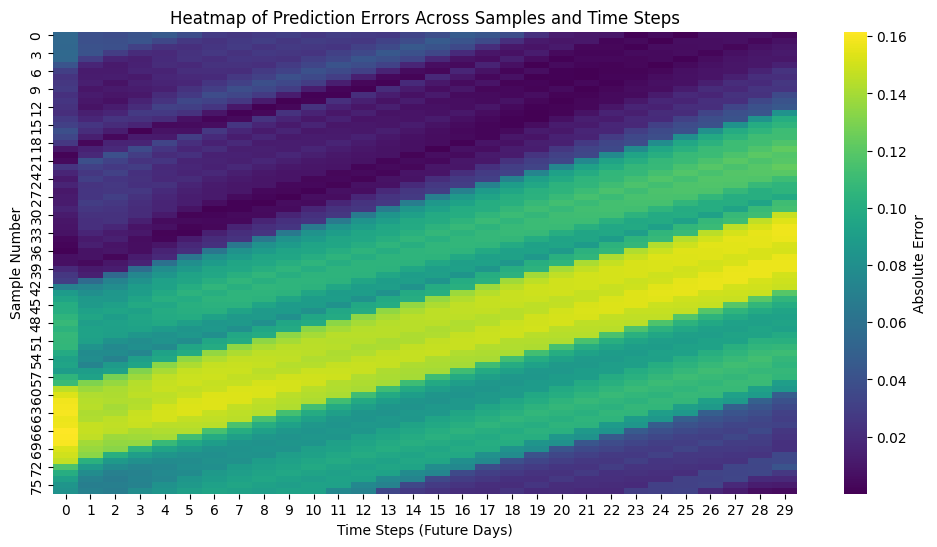

In [ ]:
import seaborn as sns

# Calculate absolute errors
errors = np.abs(y_test_inv - y_pred_inv).squeeze()

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(errors, cmap='viridis', cbar_kws={'label': 'Absolute Error'})
plt.title('Heatmap of Prediction Errors Across Samples and Time Steps')
plt.xlabel('Time Steps (Future Days)')
plt.ylabel('Sample Number')
plt.show()

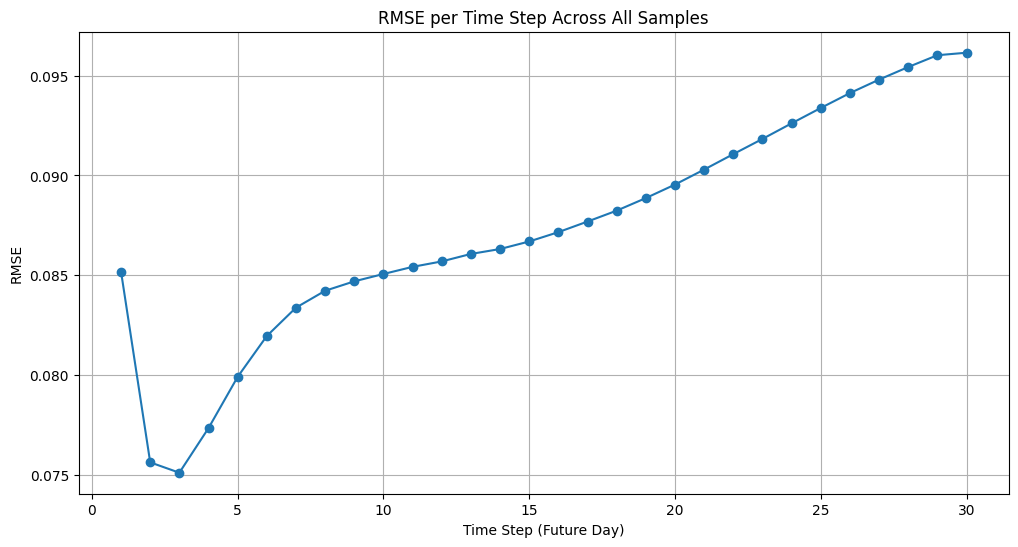

In [ ]:
from sklearn.metrics import mean_squared_error

# Initialize list to store RMSE for each time step
rmse_per_timestep = []

for t in range(y_test_inv.shape[1]):
    y_true_t = y_test_inv[:, t, 0]
    y_pred_t = y_pred_inv[:, t, 0]
    rmse_t = np.sqrt(mean_squared_error(y_true_t, y_pred_t))
    rmse_per_timestep.append(rmse_t)

# Plot RMSE per time step
plt.figure(figsize=(12, 6))
plt.plot(range(1, y_test_inv.shape[1] + 1), rmse_per_timestep, marker='o')
plt.title('RMSE per Time Step Across All Samples')
plt.xlabel('Time Step (Future Day)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()